# Constraint Handling

Penalize individuals with evaluation results that fall outside the desired region. This allows to speed up the optimization process. 

The penalty function gives a fitness disadvantage to the individuals according to the number of constraint violations and to the severity of that violations. This code uses an exponencial funtion, with offset, to apply the penalization.


The last version of this document is available [here](https://github.com/mdmfernandes/smoc-extras).

## Author

* **Miguel Fernandes** - [mdmfernandes @ GitHub](https://github.com/mdmfernandes)

In [1]:
# Imports
import numpy as np

import math

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Constraints limits and fitness

BW_MIN = 5e6
BW_MAX = 6e6

REG_MIN = 2
REG_MAX = 3

FITNESS = (0.01, 100)

penalty_weight = 1.2

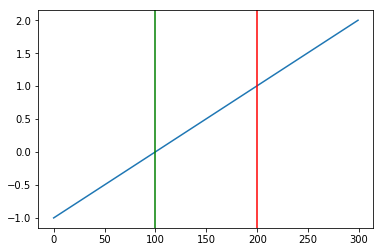

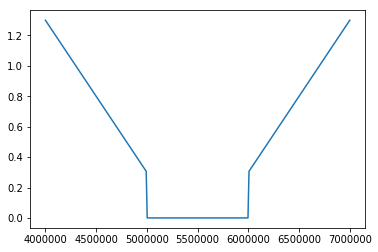

In [3]:
# BANDWIDTH

BW = np.linspace(4e6, 7e6, 300)

BW_og = BW

dy = 0.3;

# Normalize BW
BW = (BW - BW_MIN) / (BW_MAX - BW_MIN)

plt.plot(BW)

plt.plot()
plt.axvline(x=100, color='green')
plt.axvline(x=200, color='red')


fig, ax = plt.subplots()

penalty = np.zeros(len(BW))

for idx in range(len(BW)):
    if BW[idx] < 0:
        penalty[idx] = dy + (-BW[idx])
    elif BW[idx] > 1:
        penalty[idx] = dy + (BW[idx] - 1)
    else:
        penalty[idx] = 0
    
#y = np.exp(x)

ax.plot(BW_og,penalty)

penalty_bw = penalty

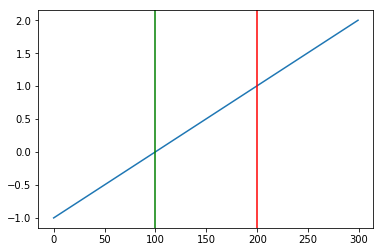

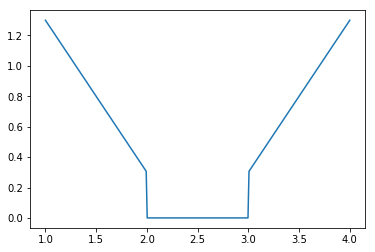

In [4]:
# REGION

REG = np.linspace(1, 4, 300)

REG_og = REG

dy = 0.3;

# Normalize BW
REG = (REG - REG_MIN) / (REG_MAX - REG_MIN)

plt.plot(REG)


plt.plot()
plt.axvline(x=100, color='green')
plt.axvline(x=200, color='red')


fig, ax = plt.subplots()

penalty = np.zeros(len(REG))

for idx in range(len(REG)):
    if REG[idx] < 0:
        penalty[idx] = dy + (-REG[idx])
    elif REG[idx] > 1:
        penalty[idx] = dy + (REG[idx] - 1)
    else:
        penalty[idx] = 0
    
#y = np.exp(x)

ax.plot(REG_og,penalty)

penalty_reg = penalty

1.0491638795986622
1.0591973244147153


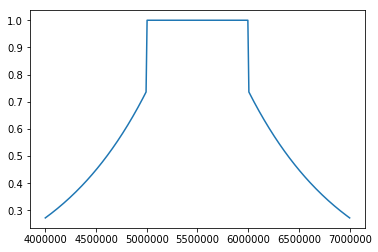

In [5]:
# MAXIMIZAR com 1 constraint (BW)
    
print(penalty_bw[25])
print(penalty_bw[275])
    
plt.plot(BW_og,np.exp(-penalty_bw))

1.0491638795986622
1.0491638795986622


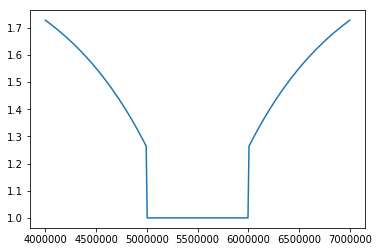

In [6]:
# MINIMIZAR com 1 constraint (BW)

print(penalty_bw[25])
print(penalty_bw[274])
    
plt.plot(BW_og,(2 - np.exp(-penalty_bw)))

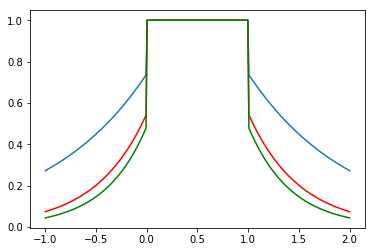

In [7]:
# MAXIMIZAR COM 2 CONSTRAINTS

fig, ax = plt.subplots()
ax.plot(BW,np.exp(-penalty_bw))                                 # 1 constraint
penalty_tot = penalty_bw + penalty_reg
ax.plot(BW,np.exp(-penalty_tot), color='red')                   # 2 constraints
ax.plot(BW,np.exp(-penalty_weight*penalty_tot), color='green')  # 2 constraints weighted

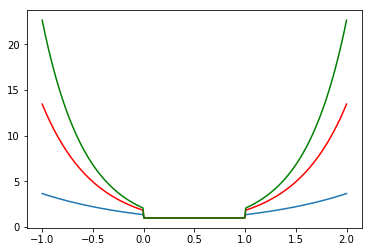

In [8]:
# MINIMIZAR COM 2 CONSTRAINTS

fig, ax = plt.subplots()
ax.plot(BW, np.exp(penalty_bw))                               # 1 constraint
penalty_tot = penalty_bw + penalty_reg
ax.plot(BW, np.exp(penalty_tot), color='red')  # 2 constraints

ax.plot(BW, np.exp(penalty_weight*penalty_tot), color='green')  # 2 constraints weighted

## Multiple constraints!

In [9]:
constraints = {
    'BW': [5e6, 6e6],   
    'REG': [2, 3]
}

sim_res = {
    'BW': 4.5e6,   
    'REG': 2
}

dy = 0;


penalty = 0

for key, val in constraints.items():
    
    # Normalize the simulation result
    res_norm = (sim_res[key] - val[0]) / (val[1] - val[0])
    
    print("RES NORM:", res_norm)

    # Check the limits
    if res_norm < 0:
        penalty += dy + (-res_norm)
    elif res_norm > 1:
        penalty += dy + (res_norm - 1)

    
print("Penalty:", penalty)

penalty_weight = 1

print("Fitness min", np.exp(penalty_weight*penalty))
print("Fitness max", np.exp(-penalty_weight*penalty))

RES NORM: -0.5
RES NORM: 0.0
Penalty: 0.5
Fitness min 1.6487212707001282
Fitness max 0.6065306597126334


In [10]:
objectives = {
    'POWER': -1.0,
    'GAIN': 1.0
}

constraints = {
    'BW': [5e6, 6e6],   
    'REG': [2, 2]
}

# Simulation results
sim_res = {
    'BW': 5.5e6,   
    'REG': 2.5,
    'POWER': -10e-6,
    'GAIN': 36
}
    
penalty_delta = 2;
penalty_weight = 1;


pen = 0


for key, val in constraints.items():
    # Try to compute the penalty (if constraint has two limits)
    try:
        # Try to convert the values to float
        val_0 = float(val[0])
        val_1 = float(val[1])

        
        # Normalize the simulation result
        if val_0 != val_1:
            res_norm = (sim_res[key] - val_0) / (val_1 - val_0)
            # Check the limits
            if res_norm < 0:
                pen += penalty_delta - res_norm
            elif res_norm > 1:
                pen += penalty_delta + (res_norm - 1)
        elif val_0 == val_1 and sim_res[key] != val_0:
            pen += penalty_delta + math.fabs(sim_res[key] - val_0)


    # If contraint only has one limit
    except (TypeError, ValueError):

        # True - defined, false - undefined
        limit = [True, True]

        for lim, value in enumerate(val):
            try:
                # Get the constraint value and normalize it
                res_norm = (sim_res[key] / float(value)) - 1
            # If can't convert to float, the limit is not defined
            except (TypeError, ValueError):
                limit[lim] = False

        # If founds two limits, it should be handled in the previous 'try'
        if limit[0] and limit[1]:
            raise TypeError("Both limits exist.. it shouldn't come here!!!")

        # If constraint has maximum allowed value
        if not limit[0] and res_norm > 0:
            pen += penalty_delta + res_norm

        # If constraint has minimum allowed value
        elif not limit[1] and res_norm < 0:
            pen += penalty_delta - res_norm

print("Penalty:", pen)

penalty_weight = 1

print("Fitness min:", math.exp(penalty_weight*pen))
print("Fitness max:", math.exp(-penalty_weight*pen))

fitness = []  # Fitnesses of one individual
            
for key, val in objectives.items():
    try:
        # Add the penalty weight to penalty
        penalty = pen * penalty_weight

        # Avoid overflow problems
        if penalty > 500:
            penalty = 500
            
        # Get the desired simulation result
        result = sim_res[key]

        # If the fitness is to maximize, change the penalty signal
        if val > 0:
            penalty = -penalty
            
       
        tot_penalty = math.exp(penalty_weight*penalty)
        
        # If the simulation result is negative, invert the penalty
        if result < 0:
            tot_penalty = 1 / tot_penalty
                
        fitness.append(result * tot_penalty)
    except KeyError as err:
        raise KeyError(
            f"Eval circuit: there's no key {err} in the simulation results.")

print("FITNESS:", fitness)

Penalty: 2.5
Fitness min: 12.182493960703473
Fitness max: 0.0820849986238988
FITNESS: [-8.208499862389881e-07, 2.955059950460357]
